In [1]:
import os, sys
import pandas as pd
import numpy as np
import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import gc
from IPython.display import display  # Helps visualize DataFrames in Jupyter

### Pull data

In [2]:
# Define the file path
data_path = "/Users/kalyanilimaye/Desktop/Research/mimicdata/data/"

# Read the CSV files
admissions = pd.read_csv(data_path + "admissions.csv.gz")
patients = pd.read_csv(data_path + "patients.csv.gz")
diagnoses = pd.read_csv(data_path + "diagnoses_icd.csv.gz")
d_diagnoses = pd.read_csv(data_path + "d_icd_diagnoses.csv.gz")
input_events = pd.read_csv(data_path + "inputevents.csv.gz") #for subjects
d_labitems = pd.read_csv(data_path + "d_labitems.csv.gz")
d_items = pd.read_csv(data_path + "d_items.csv.gz") #for meds

In [3]:
import random
import torch
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Call before training

### Meds

In [4]:
meds = [225166] #Potassium Chloride (IV)225166
meds_map = d_items[d_items['itemid'].isin(meds)][['itemid', 'label', 'category',]].drop_duplicates()
meds_map.head(5)

,itemid,label,category
1121,225166,Potassium Chloride,Medications


In [5]:
meds_admin = input_events[input_events['itemid'].isin(meds)] #IV med
meds_admin = meds_admin[meds_admin['amountuom'] == 'mEq'] #there was only a single non-mEq patient, so remove

In [6]:
#remove outliers: keep rows whose `amount` is ≤ the 99-th percentile
p99 = (
    meds_admin
      .groupby('itemid')['amount']
      .transform(lambda s: s.quantile(0.99))
)

meds_admin = meds_admin[meds_admin['amount'] <= p99]

In [7]:
#check range
med_ranges = (
    meds_admin
        .groupby('itemid')['amount']
        .agg(min_val='min', max_val='max')
        .assign(range_width=lambda df: df.max_val - df.min_val)
)

med_ranges.head()

,min_val,max_val,range_width
itemid,,,
225166,0.0,40.000001,40.000001


#### subjects taking K meds

In [8]:
#Filtered by meds - all patients who received meds listed above
subjects_by_meds = meds_admin['subject_id']
subjects_by_meds.unique().shape

(27182,)

In [9]:
subject_ids = subjects_by_meds.unique()[:2000]

#### discretize

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Round doses to nearest integer
meds_admin['dose_int'] = meds_admin['amount'].round().astype('Int64')

# 2) Count unique patients per rounded dose
patient_counts = (
    meds_admin
    .dropna(subset=['dose_int'])
    .groupby('dose_int')['subject_id']
    .nunique()
    .sort_index()
)

#print(patient_counts)

In [11]:
mapping = {
    0:  0,   # keep zeros
    10: 10,  # keep exact 10’s
    20: 20,  # keep exact 20’s
    40: 40   # keep exact 40’s
}

# now map neighbors into those bins:
for d in [1,2,3, 4]:
    mapping[d] = 0
for d in [5, 6,7, 8, 9, 11, 12, 13,14]:
    mapping[d] = 10
for d in [15,16,17,18, 19, 21, 22,23,24]:
    mapping[d] = 20
for d in [31,32,33,34,35,36,37,38, 39]:
    mapping[d] = 40

meds_admin['dose_bucket'] = meds_admin['dose_int'].map(mapping)

#Re-count unique patients per kept bucket
collapsed_counts = (
    meds_admin
    .dropna(subset=['dose_bucket'])
    .groupby('dose_bucket')['subject_id']
    .nunique()
    .sort_index()
)

#print(collapsed_counts)


### Labs

#### filter chartevents and write to csv

In [12]:
'''
chartevents_file = data_path + "chartevents.csv.gz"

# Read in chunks and filter
filtered_chunks = []
chunk_size = 50000  #Adjust based on RAM availability

for chunk in pd.read_csv(chartevents_file, compression='gzip', chunksize=chunk_size):
    # Filter only for relevant subject_ids
    filtered_chunk = chunk[chunk['subject_id'].isin(subject_ids)]
    
    if not filtered_chunk.empty:
        filtered_chunks.append(filtered_chunk)

    # Force garbage collection to free memory
    del chunk
    gc.collect()

# Combine filtered results
filtered_by_subject = pd.concat(filtered_chunks, ignore_index=True)

# Save the filtered dataset
filtered_by_subject.to_csv(data_path + "filtered_chartevents.csv.gz", compression="gzip", index=False)

print(f"✅ Successfully saved filtered chartevents. Shape: {filtered_by_subject.shape}")
'''

'\nchartevents_file = data_path + "chartevents.csv.gz"\n\n# Read in chunks and filter\nfiltered_chunks = []\nchunk_size = 50000  #Adjust based on RAM availability\n\nfor chunk in pd.read_csv(chartevents_file, compression=\'gzip\', chunksize=chunk_size):\n    # Filter only for relevant subject_ids\n    filtered_chunk = chunk[chunk[\'subject_id\'].isin(subject_ids)]\n    \n    if not filtered_chunk.empty:\n        filtered_chunks.append(filtered_chunk)\n\n    # Force garbage collection to free memory\n    del chunk\n    gc.collect()\n\n# Combine filtered results\nfiltered_by_subject = pd.concat(filtered_chunks, ignore_index=True)\n\n# Save the filtered dataset\nfiltered_by_subject.to_csv(data_path + "filtered_chartevents.csv.gz", compression="gzip", index=False)\n\nprint(f"✅ Successfully saved filtered chartevents. Shape: {filtered_by_subject.shape}")\n'

In [13]:
#get ALL labs for subjects taking K meds. chartevents = labs, inputevents = meds administered to subjects, d_items = med names
all_labs = pd.read_csv(data_path + "filtered_chartevents.csv.gz")

In [14]:
lab_values = [227442, 227464] # Potassium serum, Potassium (whole blood)

#to see names
lab_map = d_items[d_items['itemid'].isin(lab_values)][['itemid', 'label', 'category', ]].drop_duplicates()
lab_map.head(5)

,itemid,label,category
2203,227442,Potassium (serum),Labs
2225,227464,Potassium (whole blood),Labs


#### subjects with atleast one specified K lab

In [15]:
#filter hardcoded labs only
relevant_labs = all_labs[all_labs['itemid'].isin(lab_values)]

#remove outliers: keep rows whose `value` is ≤ the 99-th percentile
p99_l = (
    relevant_labs
      .groupby('itemid')['valuenum']
      .transform(lambda s: s.quantile(0.99))
)

relevant_labs = relevant_labs[relevant_labs['valuenum'] <= p99_l]

In [16]:
subj_counts_labs = (
    relevant_labs          # your DataFrame
      .groupby(['itemid','valueuom'])['subject_id']
      .nunique()                    # distinct patients in each group
      .reset_index(name='n_subjects')
)

subj_counts_labs.head(3)

,itemid,valueuom,n_subjects
0,227442,mEq/L,1996
1,227464,mEq/L,1214


In [17]:
# basic min & max of the potassium labs (or any lab values)
lab_ranges = (
    relevant_labs
        .groupby('itemid')['valuenum']
        .agg(min_val='min', max_val='max')
        .assign(range_width=lambda df: df.max_val - df.min_val)
)

lab_ranges.head()

,min_val,max_val,range_width
itemid,,,
227442,0.0,6.1,6.1
227464,1.4,6.4,5.0


In [18]:
# Count unique patients at each integer‐rounded value for itemid 227442:
lab_counts_227442 = (
    relevant_labs
      .loc[relevant_labs['itemid'] == 227442]           # filter to K serum
      .assign(lab_int=lambda df: df['valuenum']          # round to nearest int
                                    .round()
                                    .astype(int))
      .dropna(subset=['lab_int'])                        # drop any NaNs
      .groupby('lab_int')['subject_id']                  # group by the rounded value
      .nunique()                                         # count distinct subjects
      .sort_index()                                      # sort by lab_int
)

print(lab_counts_227442)


lab_int
0       1
1       2
2      55
3    1059
4    1923
5    1021
6     257
Name: subject_id, dtype: int64


In [19]:
relevant_labs = relevant_labs.loc[relevant_labs['valuenum'] >= 1.4] #remove the 0,1 measurements they seem like outliers based on above

In [20]:
#filter subjects to only those with atleast 1 lab
subject_ids = relevant_labs['subject_id'].unique()
labs_taken = relevant_labs[relevant_labs['subject_id'].isin(subject_ids)]
labs_taken.shape

(37900, 11)

In [21]:
len(subject_ids)

1997

### check stats , plot - meds + labs

In [22]:
stats_meds = meds_admin.groupby('itemid')['amount'].describe().round(2)
stats_labs = labs_taken.groupby('itemid')['valuenum'].describe().round(2)
display(stats_meds)
display(stats_labs)

,count,mean,std,min,25%,50%,75%,max
itemid,,,,,,,,
225166,200862.0,18.29,5.81,0.0,20.0,20.0,20.0,40.0


,count,mean,std,min,25%,50%,75%,max
itemid,,,,,,,,
227442,29087.0,4.07,0.58,1.6,3.7,4.0,4.4,6.1
227464,8813.0,4.14,0.67,1.4,3.7,4.1,4.5,6.4


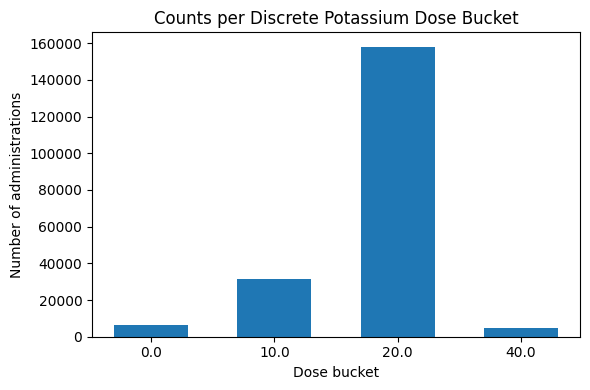

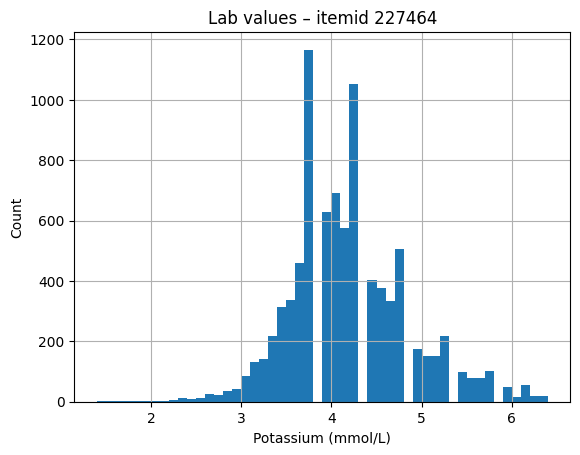

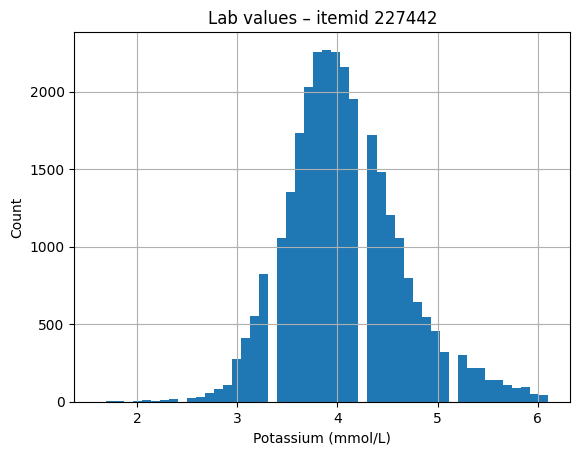

In [23]:
import matplotlib.pyplot as plt

# Histogram for medication doses (meds_admin['amount'])
import matplotlib.pyplot as plt

# 1) Get counts per bucket, sorted by bucket value
counts = meds_admin['dose_bucket'] \
            .dropna() \
            .value_counts() \
            .sort_index()

# 2) Plot as a bar chart
plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values, width=0.6)
plt.xlabel("Dose bucket")
plt.ylabel("Number of administrations")
plt.title("Counts per Discrete Potassium Dose Bucket")
plt.tight_layout()
plt.show()


# Histogram for potassium lab values (labs_taken['valuenum'])
for iid in labs_taken['itemid'].unique():
    labs_taken.loc[labs_taken.itemid == iid, 'valuenum'].dropna().hist(bins=50)
    plt.title(f'Lab values – itemid {iid}')
    plt.xlabel('Potassium (mmol/L)')
    plt.ylabel('Count')
    plt.show()        # shows one figure, then continues to next id


### Trajectory functions

In [24]:
# itemid → canonical feature name
ITEMIDS = {
    220045: "heart_rate",
    220210: "resp_rate",
    220179: "systolic_bp",
    220180: "diastolic_bp",
    220615: "creatinine_serum",
    227073: "anion_gap_serum"
}

# all_labs is already in memory with columns: subject_id, hadm_id, itemid, charttime, valuenum …
stats = (
    all_labs[all_labs["itemid"].isin(ITEMIDS.keys())]
      .dropna(subset=["valuenum"])
      .groupby("itemid")["valuenum"]
      .agg(mean_value="mean", n_rows="size")
      .reset_index()
)

stats["feature_name"] = stats["itemid"].map(ITEMIDS)
stats = stats[["itemid", "feature_name", "mean_value", "n_rows"]].sort_values("feature_name")
stats


,itemid,feature_name,mean_value,n_rows
5,227073,anion_gap_serum,14.125890,27373
4,220615,creatinine_serum,1.584772,27534
2,220180,diastolic_bp,66.794095,230164
0,220045,heart_rate,86.833304,394884
3,220210,resp_rate,20.239264,390958
1,220179,systolic_bp,118.979193,230203


In [25]:
mimic_labels = [
    'Heart Rate',
    'Respiratory Rate',
    'Non Invasive Blood Pressure systolic',
    'Non Invasive Blood Pressure diastolic',
    'Creatinine (serum)',
    'Anion gap'
]

label_to_itemid = (
    d_items[d_items['label'].isin(mimic_labels)]
      .drop_duplicates(subset='label')      # just in case
      .set_index('label')['itemid']
      .to_dict()
)

print(label_to_itemid)

{'Heart Rate': 220045, 'Non Invasive Blood Pressure systolic': 220179, 'Non Invasive Blood Pressure diastolic': 220180, 'Respiratory Rate': 220210, 'Creatinine (serum)': 220615, 'Anion gap': 227073}


In [26]:
from datetime import timedelta
import numpy as np
import pandas as pd

MIMIC_ITEM_IDS = {
    220045: "heart_rate",
    220179: "systolic_bp",
    220180: "diastolic_bp",
    220210: "resp_rate",
    220615: "creatinine_serum",   # Creatinine (serum)
    227073: "anion_gap_serum"     # Anion gap
}

def get_extra_measurements(meas_df, start, end, id_map=MIMIC_ITEM_IDS, dt_hours=4):
    """
    Mean of each ITEMID in [start,end).  If absent, look ±1,±2,±3 windows
    of size dt_hours.  Missing → 0.0.  Order follows id_map.
    
    meas_df must have ['itemid','charttime','valuenum'].
    """
    if meas_df['charttime'].dtype == object:
        meas_df = meas_df.copy()                                    
        meas_df['charttime'] = pd.to_datetime(
            meas_df['charttime'], errors='coerce'
        )   
    def window_mean(iid, st, en):
        vals = meas_df[
            (meas_df['itemid'] == iid) &
            (meas_df['charttime'] >= st) &
            (meas_df['charttime'] <  en)
        ]['valuenum'].dropna()
        return float(vals.mean()) if not vals.empty else None

    offsets = [-1, 1, -2, 2, -3, 3]
    out = {}
    for iid, name in id_map.items():
        val = window_mean(iid, start, end) #checks 0 first 
        if val is None:
            for off in offsets:
                st = start + timedelta(hours=off * dt_hours)
                en = end   + timedelta(hours=off * dt_hours)
                val = window_mean(iid, st, en)
                if val is not None:
                    break
        out[name] = val if val is not None else 0.0
    return out

In [27]:
mimic_units = (
    d_items[d_items['itemid'].isin(MIMIC_ITEM_IDS.keys())]
      .drop_duplicates(subset='itemid')[['itemid', 'unitname']]
      .set_index('itemid')['unitname']
      .apply(lambda u: u or '—')
      .to_dict()
)
print("MIMIC units:", mimic_units)

MIMIC units: {220045: 'bpm', 220179: 'mmHg', 220180: 'mmHg', 220210: 'insp/min', 220615: nan, 227073: nan}


In [28]:
# Helper function to get patient info
def get_patient_info(subject_id):
    patient = patients[patients['subject_id'] == subject_id]
    meds_by_id = input_events[(input_events['subject_id']==subject_id)]
    return {
        'age': patient['anchor_age'].item(),
        'gender': 1 if patient['gender'].item() == 'F' else 0,
        'weight': meds_by_id.iloc[0]['patientweight']
    }

In [29]:
def potassium_reward(k, mu=4.25, sigma=0.5, clip=True): #Gaussian reward
    k_arr = np.array(k, dtype=np.float32)
    # Compute exponent: -(1/2)*((k-mu)/sigma)^2
    ex = -0.5 * ((k_arr - mu) / sigma) ** 2
    r = np.exp(ex)

    if clip:
        # any NaN inputs → reward 0
        r = np.where(np.isnan(r), 0.0, r)
        # just in case numerical underflow yields tiny negatives
        r = np.clip(r, 0.0, 1.0)
    return r

In [30]:
def interpolate_K_lab(patient_labs, start_time, end_time, lab_itemids, time_delta):
    """
    Return one potassium value for [start_time, end_time):
      1. If any serum (lab_itemids[0]) in window → its mean.
      2. Else if any whole‐blood (lab_itemids[1]) → its mean.
      3. Else search offsets +1, -1, +2, -2 windows in that order,
         each time preferring serum then whole‐blood.
      4. If still nothing → np.nan.
    """
    def window_mean(iid, st, en):
        vals = patient_labs[
            (patient_labs['charttime'] >= st) &
            (patient_labs['charttime'] <  en)   &
            (patient_labs['itemid']   == iid)
        ]['valuenum']
        return vals.mean() if not vals.empty else None

    # 1) Try current window
    serum = window_mean(lab_itemids[0], start_time, end_time)
    if serum is not None:
        return serum
    wb = window_mean(lab_itemids[1], start_time, end_time)
    if wb is not None:
        return wb

    
    # 2) Search neighbors in order +1, -1, +2, -2
    for offset in (1, -1, 2, -2,3, -3):
        st = start_time + timedelta(hours=offset * time_delta)
        en = end_time   + timedelta(hours=offset * time_delta)
        serum = window_mean(lab_itemids[0], st, en)
        if serum is not None:
            return serum
        wb = window_mean(lab_itemids[1], st, en)
        if wb is not None:
            return wb

    # 3) Nothing found
    return 0.0

In [31]:
def find_sandwich(patient_labs, patient_meds, admittime, lab_itemids, time_delta, med_itemid):
    """
    For each KCl dose in patient_meds, interpolate the potassium lab
    in the 4h window *before* the dose and the 4h window *after*.
    Returns a list of tuples:
        (dose_amount, K_before, K_after)
    """
    sandwiches = []
    for _, row_med in patient_meds[patient_meds['itemid']==med_itemid].iterrows():
        t = row_med['starttime']
        # before window = [t - time_delta, t)
        K_before = interpolate_K_lab(
            patient_labs, 
            t - timedelta(hours=time_delta), t,
            lab_itemids, time_delta
        )
        # after  window = [t, t + time_delta)
        K_after  = interpolate_K_lab(
            patient_labs, 
            t, t + timedelta(hours=time_delta),
            lab_itemids, time_delta
        )
        if not np.isnan(K_before) and not np.isnan(K_after):
            sandwiches.append((row_med['dose_bucket'], K_before, K_after))
    return sandwiches

In [32]:
def interpolate_offset(labs, anchor_time, time_delta, direction='after'):
    """
    Search ±1 or ±2 bins from anchor_time for a lab value.
    direction='after' looks at [anchor+4h, anchor+8h], etc.
    direction='before' looks at [anchor-4h, anchor), [anchor-8h, anchor-4h].
    Returns (mean_value, offset) or (np.nan, None) if none found.
    """
    for off in (1, 2, 3):
        if direction == 'after':
            st = anchor_time + timedelta(hours=off * time_delta)
            en = st + timedelta(hours=time_delta)
        else:  # 'before'
            en = anchor_time - timedelta(hours=(off - 1) * time_delta)
            st = en - timedelta(hours=time_delta)
        window = labs[(labs['charttime'] >= st) & (labs['charttime'] < en)]
        if not window.empty:
            return window['valuenum'].max(), off
    return 0.0, 0

In [33]:
def get_before_after(labs, start, end, med_time, time_delta):
    """
    Returns (lab_before, lab_after, offset), or (np.nan, np.nan, None) if missing.
    Uses interpolate_offset() for the ±1/±2‐bin searches.
    """
    offset = 0
    w = labs[(labs['charttime'] >= start) & (labs['charttime'] < end)]

    bef = w[w['charttime'] < med_time]
    if not bef.empty:
        lab_before = bef.iloc[-1]['valuenum']
    else:
        lab_before, _ = interpolate_offset(labs, start, time_delta, direction='before')

    aft = w[w['charttime'] >= (med_time + timedelta(minutes=30))]
    if not aft.empty:
        lab_after = aft.iloc[0]['valuenum']
        offset = 0
    else:
        lab_after, offset = interpolate_offset(labs, end, time_delta, direction='after')

    return lab_before, lab_after, offset


In [34]:
def is_sparse(stay_states,
              stay_actions,
              min_steps=6,
              min_lab_ratio=0.6,    # ≥60 % bins have lab_before > 0
              min_act_ratio=1/12):  # ≥1/12 bins have action > 0
    """
    Returns True  ⇐  stay should be DROPPED.
    Criteria (all must fail → drop):

      1) T = len(stay_states)  must be ≥ min_steps
      2) (lab_before > 0) fraction ≥ min_lab_ratio
      3) (action  > 0)   fraction ≥ min_act_ratio
    """
    T = len(stay_states)
    if T < min_steps:
        return True

    arr = np.asarray(stay_states, dtype=float)
    lab_before = arr[:, 3]                         # column 3
    lab_ratio  = (lab_before > 0.0).mean()

    actions = np.asarray(stay_actions, dtype=float)
    act_ratio = (actions > 0.0).mean()             # non-zero doses

    return (lab_ratio < min_lab_ratio) or (act_ratio < min_act_ratio)


#### create fn

In [35]:
import numpy as np
from datetime import datetime, timedelta

gamma = 0.99  # discount for delayed lab rewards

#Features configuration
standard_features = ['age', 'gender', 'weight']
lab_itemids = [227442, 227464]  # Potassium serum and whole blood item IDs
med_itemid = 225166  # Potassium Chloride item ID

time_delta = 4  # hours

def construct_trajectory(subject_id):
    # Get patient static info
    patient_info = get_patient_info(subject_id)

    # Get all labs and meds for this patient
    patient_labs_all = labs_taken[labs_taken['subject_id']==subject_id].copy()
    patient_meds_all = meds_admin[meds_admin['subject_id']==subject_id].copy()

    # parse timestamps once
    if not patient_labs_all.empty and isinstance(patient_labs_all['charttime'].iloc[0], str):
        patient_labs_all['charttime'] = pd.to_datetime(patient_labs_all['charttime'])
    if not patient_meds_all.empty and isinstance(patient_meds_all['starttime'].iloc[0], str):
        patient_meds_all['starttime'] = pd.to_datetime(patient_meds_all['starttime'])

    # trajectory accumulators
    patient_states = []
    patient_actions = []
    patient_rewards = []

    hadms = patient_labs_all['hadm_id'].unique()
    print(f"Subject {subject_id} has {len(hadms)} stays with atleast one lab")

    # loop each hospital stay
    for hadm_id in hadms:
        
        stay_states = []
        stay_actions = []
        stay_rewards = []
    
        labs = patient_labs_all[patient_labs_all['hadm_id']==hadm_id].copy()
        meds = patient_meds_all[patient_meds_all['hadm_id']==hadm_id].copy()

        admission = admissions[admissions['hadm_id']==hadm_id]
        admittime = datetime.strptime(admission['admittime'].item(), "%Y-%m-%d %H:%M:%S")
        dischtime = datetime.strptime(admission['dischtime'].item(), "%Y-%m-%d %H:%M:%S")

        #restrict to stay window
        labs = labs[(labs['charttime'] >= admittime) & (labs['charttime'] <= dischtime)]
        meds = meds[(meds['starttime'] >= admittime) & (meds['starttime'] <= dischtime)]

        #skip if no labs or meds in the whole STAY
        if labs.empty:
            #print(f"Stay {hadm_id}: no labs, skipping")
            continue
        if meds.empty:
            #print(f"Stay {hadm_id}: no meds, skipping")
            continue

        last_lab_time = labs['charttime'].max()
        effective_end_time = min(last_lab_time, dischtime)

        #compute how many 4h intervals fit in the stay
        total_hours = int((effective_end_time - admittime).total_seconds() / 3600)
        n_intervals = total_hours // time_delta
        
        # per-stay interval counters
        total_intervals = 0
        skipped_intervals = 0

        for i in range(n_intervals):
            total_intervals += 1

            start = admittime + timedelta(hours=i * time_delta)
            end   = start   + timedelta(hours=time_delta)

            # 1) action & med_time
            window_meds = meds[(meds['starttime'] >= start) & (meds['starttime'] < end)]
            if not window_meds.empty:
                action = int(window_meds['dose_bucket'].max()) #maybe sum is more appropriate here
                med_time = window_meds['starttime'].iloc[0]
            else:
                action = 0
                med_time = end

            # 2) lab_window & skip check
            window_labs = labs[(labs['charttime'] >= start) & (labs['charttime'] < end)]

            if window_labs.empty:
                K_interp = interpolate_K_lab(labs, start, end, lab_itemids, time_delta)

            # 3) find before/after labs
            lab_before, lab_after, offset = get_before_after(
                labs, start, end, med_time, time_delta
            )
            if np.isnan(lab_before): 
                print("before is null for interval ", i)
                skipped_intervals += 1
                continue
            if np.isnan(lab_after):
                #print("after is null for interval ", i)
                skipped_intervals += 1
                continue

            # 4) build state/action/reward
            # after labs & meds are subset for hadm_id
            extra_covariates = all_labs[
                (all_labs['subject_id'] == subject_id) &
                (all_labs['hadm_id']    == hadm_id)
            ]
            extra = get_extra_measurements(extra_covariates, start, end, dt_hours=time_delta)
            stay_states.append([
                patient_info['age'],
                patient_info['gender'],
                patient_info['weight'],
                lab_before,
                *extra.values()
            ])
            stay_actions.append(action)
            reward = potassium_reward(lab_after, mu=4.25, sigma=0.5)
            reward *= 100
            if offset:
                reward *= (gamma ** offset)
            stay_rewards.append(reward)

        if stay_states:
            if is_sparse(stay_states, stay_actions):                  
                print(f"Stay {hadm_id}: sparse → dropped")
                continue 
            patient_states.append(stay_states)
            patient_actions.append(stay_actions)
            patient_rewards.append(stay_rewards)
        #print(f"Stay {hadm_id}: skipped {skipped_intervals}/{total_intervals} intervals")

    return patient_states, patient_actions, patient_rewards


### Single patient testing
now for debugging purposes

In [36]:
test_id = 10002013
test_hadm_id = 20321825

In [37]:
patient_meds_all = meds_admin[meds_admin['subject_id'] == test_id].copy()
patient_meds_all.shape
patient_meds_all.head(3)
patient_labs_check = labs_taken[labs_taken['hadm_id'] == test_hadm_id].copy()
patient_labs_check.head(5)
patient_labs_check.shape
patient_info = get_patient_info(test_id)
patient_info

{'age': 53, 'gender': 1, 'weight': np.float64(96.0)}

#### test traj

In [38]:
states, actions, rewards = construct_trajectory(test_id)

Subject 10002013 has 1 stays with atleast one lab
Stay 23581541: sparse → dropped


In [39]:
len(actions)

0

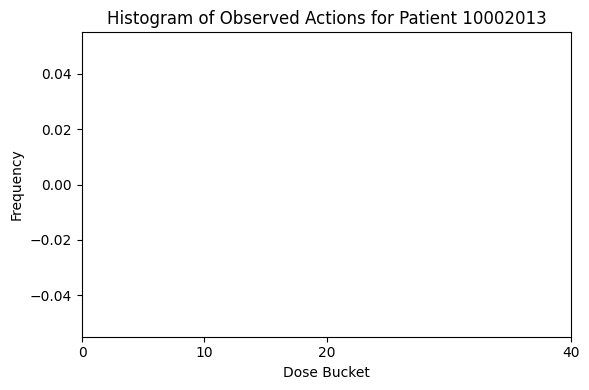

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# flatten nested lists/arrays → [0, 10, 0, 20, …]
flat_acts = [
    int(a[0]) if isinstance(a, (list, np.ndarray)) else int(a)
    for sub in actions          # actions = [[0,10,…], [0,0,…], …]  OR [[0], [10], …]
    for a in (sub if isinstance(sub, (list, np.ndarray)) else [sub])
]

acts = np.array(flat_acts, dtype=int)

# bucket counts
unique_buckets, counts = np.unique(acts, return_counts=True)

# bar chart
plt.figure(figsize=(6, 4))
plt.bar(unique_buckets, counts, width=8, edgecolor='k')
plt.xticks([0, 10, 20, 40])
plt.xlabel("Dose Bucket")
plt.ylabel("Frequency")
plt.title(f"Histogram of Observed Actions for Patient {test_id}")
plt.tight_layout()
plt.show()


### Test for 10 patients

In [41]:
train_subject_ids = subject_ids[:200]
#test_subject_ids = subject_ids[30:60]

#### Construct trajectories

In [42]:
import tqdm
def build_expert_trajectories(subject_ids):
    """
    Collect every *stay* as an individual trajectory.
    """
    trajectory_states = []
    trajectory_actions = []
    trajectory_rewards = []
    trajectory_sum_rewards = []

    for subject_id in tqdm.tqdm(subject_ids):
        try:
            # each is now  [stay1, stay2, …]
            states_list, actions_list, rewards_list = construct_trajectory(subject_id)

            # ── NEW: push every stay separately ───────────────────────────
            for s, a, r in zip(states_list, actions_list, rewards_list):
                if s and a and r:
                    trajectory_states.append(s)
                    trajectory_actions.append(a)
                    trajectory_rewards.append(r)
                    trajectory_sum_rewards.append(sum(r))
            # ──────────────────────────────────────────────────────────────

        except Exception as e:
            print(f"Error processing subject {subject_id}: {str(e)}")
            continue

    return {
        'states'      : trajectory_states,
        'actions'     : trajectory_actions,
        'rewards'     : trajectory_rewards,
        'reward_sum'  : trajectory_sum_rewards
    }


In [43]:
train_expert_trajectories = build_expert_trajectories(train_subject_ids)
#test_expert_trajectories = build_expert_trajectories(test_subject_ids)

  0%|                                                   | 0/200 [00:00<?, ?it/s]

Subject 10002013 has 1 stays with atleast one lab


  0%|▏                                          | 1/200 [00:00<00:32,  6.07it/s]

Stay 23581541: sparse → dropped
Subject 10002114 has 1 stays with atleast one lab


  1%|▍                                          | 2/200 [00:00<00:50,  3.92it/s]

Subject 10002428 has 3 stays with atleast one lab
Stay 23473524: sparse → dropped


  2%|▋                                          | 3/200 [00:04<06:34,  2.00s/it]

Stay 28662225: sparse → dropped
Subject 10002430 has 1 stays with atleast one lab


  2%|▊                                          | 4/200 [00:04<04:25,  1.35s/it]

Stay 26295318: sparse → dropped
Subject 10002495 has 1 stays with atleast one lab


  2%|█                                          | 5/200 [00:05<03:35,  1.11s/it]

Stay 24982426: sparse → dropped
Subject 10002667 has 1 stays with atleast one lab


  4%|█▌                                         | 7/200 [00:05<01:54,  1.68it/s]

Subject 10002760 has 1 stays with atleast one lab
Subject 10003019 has 1 stays with atleast one lab
Stay 22774359: sparse → dropped
Subject 10003400 has 2 stays with atleast one lab
Stay 20214994: sparse → dropped


  4%|█▉                                         | 9/200 [00:13<07:02,  2.21s/it]

Stay 23559586: sparse → dropped
Subject 10004235 has 1 stays with atleast one lab


  5%|██                                        | 10/200 [00:14<05:47,  1.83s/it]

Subject 10004401 has 7 stays with atleast one lab
Stay 23920883: sparse → dropped
Stay 27939719: sparse → dropped


  6%|██▎                                       | 11/200 [00:18<07:56,  2.52s/it]

Stay 29988601: sparse → dropped
Subject 10004422 has 1 stays with atleast one lab


  6%|██▌                                       | 12/200 [00:20<06:48,  2.17s/it]

Stay 21255400: sparse → dropped
Subject 10004457 has 1 stays with atleast one lab
Stay 23251352: sparse → dropped
Subject 10004606 has 1 stays with atleast one lab


  7%|██▉                                       | 14/200 [00:21<04:16,  1.38s/it]

Stay 29242151: sparse → dropped
Subject 10004720 has 1 stays with atleast one lab


  8%|███▏                                      | 15/200 [00:21<03:45,  1.22s/it]

Stay 22081550: sparse → dropped
Subject 10004733 has 1 stays with atleast one lab


  8%|███▎                                      | 16/200 [00:22<03:41,  1.20s/it]

Stay 27411876: sparse → dropped
Subject 10004764 has 1 stays with atleast one lab


  8%|███▌                                      | 17/200 [00:23<03:02,  1.00it/s]

Subject 10005348 has 1 stays with atleast one lab


  9%|███▊                                      | 18/200 [00:23<02:30,  1.21it/s]

Subject 10005817 has 2 stays with atleast one lab
Stay 20626031: sparse → dropped


 10%|███▉                                      | 19/200 [00:27<04:52,  1.61s/it]

Stay 28661809: sparse → dropped
Subject 10005866 has 1 stays with atleast one lab


 10%|████▏                                     | 20/200 [00:27<03:48,  1.27s/it]

Subject 10005909 has 1 stays with atleast one lab


 10%|████▍                                     | 21/200 [00:28<03:16,  1.10s/it]

Stay 20199380: sparse → dropped
Subject 10006131 has 1 stays with atleast one lab


 11%|████▌                                     | 22/200 [00:28<02:29,  1.19it/s]

Subject 10006821 has 1 stays with atleast one lab
Stay 23295760: sparse → dropped
Subject 10007795 has 1 stays with atleast one lab
Subject 10007928 has 1 stays with atleast one lab


 13%|█████▍                                    | 26/200 [00:29<01:09,  2.51it/s]

Stay 20338077: sparse → dropped
Subject 10008287 has 1 stays with atleast one lab
Stay 22168393: sparse → dropped


 14%|█████▋                                    | 27/200 [00:29<00:57,  3.00it/s]

Subject 10009035 has 1 stays with atleast one lab
Stay 28324362: sparse → dropped
Subject 10009628 has 1 stays with atleast one lab


 14%|█████▉                                    | 28/200 [00:29<01:08,  2.51it/s]

Stay 25926192: sparse → dropped
Subject 10009711 has 1 stays with atleast one lab


 14%|██████                                    | 29/200 [00:30<01:35,  1.79it/s]

Stay 23299685: sparse → dropped
Subject 10010867 has 1 stays with atleast one lab


 15%|██████▎                                   | 30/200 [00:32<02:19,  1.22it/s]

Subject 10011352 has 1 stays with atleast one lab


 16%|██████▌                                   | 31/200 [00:34<03:06,  1.11s/it]

Stay 29927609: sparse → dropped
Subject 10011365 has 1 stays with atleast one lab


 16%|██████▉                                   | 33/200 [00:35<02:17,  1.21it/s]

Subject 10011398 has 1 stays with atleast one lab
Stay 27505812: sparse → dropped
Subject 10011427 has 2 stays with atleast one lab
Stay 20219031: sparse → dropped


 17%|███████▏                                  | 34/200 [00:41<06:24,  2.32s/it]

Stay 22216667: sparse → dropped
Subject 10011938 has 4 stays with atleast one lab


 18%|███████▎                                  | 35/200 [00:44<07:15,  2.64s/it]

Stay 23798746: sparse → dropped
Subject 10012055 has 1 stays with atleast one lab


 18%|███████▌                                  | 36/200 [00:45<05:37,  2.06s/it]

Stay 26779316: sparse → dropped
Subject 10012206 has 1 stays with atleast one lab
Subject 10012552 has 1 stays with atleast one lab


 20%|████████▏                                 | 39/200 [00:46<02:46,  1.03s/it]

Stay 27089790: sparse → dropped
Subject 10013049 has 1 stays with atleast one lab
Stay 22675517: sparse → dropped
Subject 10013569 has 1 stays with atleast one lab


 20%|████████▍                                 | 40/200 [00:52<05:50,  2.19s/it]

Stay 27993048: sparse → dropped
Subject 10013643 has 1 stays with atleast one lab


 20%|████████▌                                 | 41/200 [00:53<04:55,  1.86s/it]

Subject 10014078 has 1 stays with atleast one lab


 21%|████████▊                                 | 42/200 [00:53<03:47,  1.44s/it]

Subject 10014610 has 2 stays with atleast one lab


 22%|█████████                                 | 43/200 [00:54<03:17,  1.26s/it]

Stay 23258342: sparse → dropped
Subject 10014652 has 1 stays with atleast one lab


 22%|█████████▏                                | 44/200 [00:54<02:31,  1.03it/s]

Stay 25833444: sparse → dropped
Subject 10014729 has 1 stays with atleast one lab


 22%|█████████▍                                | 45/200 [00:54<02:03,  1.25it/s]

Subject 10015860 has 2 stays with atleast one lab
Stay 25085565: sparse → dropped
Subject 10015931 has 3 stays with atleast one lab


 24%|█████████▊                                | 47/200 [00:55<01:31,  1.68it/s]

Stay 22130791: sparse → dropped
Subject 10016742 has 3 stays with atleast one lab
Stay 27568122: sparse → dropped


 24%|██████████                                | 48/200 [00:56<01:35,  1.60it/s]

Stay 28506150: sparse → dropped
Subject 10016810 has 1 stays with atleast one lab


 24%|██████████▎                               | 49/200 [00:56<01:21,  1.85it/s]

Subject 10017285 has 1 stays with atleast one lab


 25%|██████████▌                               | 50/200 [00:57<01:26,  1.74it/s]

Subject 10017437 has 1 stays with atleast one lab


 26%|██████████▋                               | 51/200 [00:58<01:37,  1.53it/s]

Stay 28440971: sparse → dropped
Subject 10017492 has 1 stays with atleast one lab
Subject 10017531 has 3 stays with atleast one lab


 26%|███████████▏                              | 53/200 [01:12<08:25,  3.44s/it]

Stay 22580355: sparse → dropped
Stay 27635105: sparse → dropped
Subject 10017679 has 1 stays with atleast one lab


 27%|███████████▎                              | 54/200 [01:12<06:50,  2.81s/it]

Subject 10018081 has 2 stays with atleast one lab


 28%|███████████▌                              | 55/200 [01:16<07:03,  2.92s/it]

Stay 28861356: sparse → dropped
Subject 10018328 has 2 stays with atleast one lab


 28%|███████████▊                              | 56/200 [01:17<06:06,  2.55s/it]

Subject 10018423 has 1 stays with atleast one lab


 28%|███████████▉                              | 57/200 [01:18<04:42,  1.97s/it]

Stay 29366372: sparse → dropped
Subject 10019003 has 3 stays with atleast one lab
Stay 27525946: sparse → dropped


 29%|████████████▏                             | 58/200 [01:19<04:02,  1.70s/it]

Subject 10019172 has 1 stays with atleast one lab


 30%|████████████▍                             | 59/200 [01:19<03:16,  1.39s/it]

Subject 10019777 has 1 stays with atleast one lab


 30%|████████████▌                             | 60/200 [01:20<02:59,  1.28s/it]

Stay 27738145: sparse → dropped
Subject 10019957 has 1 stays with atleast one lab


 30%|████████████▊                             | 61/200 [01:21<02:16,  1.02it/s]

Subject 10020187 has 2 stays with atleast one lab


 31%|█████████████                             | 62/200 [01:21<02:10,  1.06it/s]

Subject 10020349 has 1 stays with atleast one lab


 32%|█████████████▏                            | 63/200 [01:23<02:29,  1.09s/it]

Stay 21891870: sparse → dropped
Subject 10020640 has 1 stays with atleast one lab


 32%|█████████████▍                            | 64/200 [01:23<01:55,  1.18it/s]

Subject 10020740 has 2 stays with atleast one lab


 32%|█████████████▋                            | 65/200 [01:27<04:09,  1.85s/it]

Stay 23831430: sparse → dropped
Subject 10020944 has 1 stays with atleast one lab


 33%|█████████████▊                            | 66/200 [01:29<03:51,  1.73s/it]

Stay 29974575: sparse → dropped
Subject 10021179 has 1 stays with atleast one lab


 34%|██████████████                            | 67/200 [01:29<03:00,  1.35s/it]

Stay 27583110: sparse → dropped
Subject 10021487 has 2 stays with atleast one lab
Stay 27660781: sparse → dropped


 34%|██████████████▎                           | 68/200 [01:33<04:38,  2.11s/it]

Subject 10021666 has 1 stays with atleast one lab
Stay 22756440: sparse → dropped
Subject 10021927 has 3 stays with atleast one lab


 35%|██████████████▋                           | 70/200 [01:34<03:06,  1.43s/it]

Stay 25202388: sparse → dropped
Subject 10022017 has 1 stays with atleast one lab


 36%|██████████████▉                           | 71/200 [01:35<02:42,  1.26s/it]

Subject 10022041 has 1 stays with atleast one lab
Stay 28909879: sparse → dropped


 36%|███████████████                           | 72/200 [01:35<02:06,  1.02it/s]

Subject 10022537 has 1 stays with atleast one lab


 36%|███████████████▎                          | 73/200 [01:43<05:56,  2.81s/it]

Subject 10022620 has 2 stays with atleast one lab


 37%|███████████████▌                          | 74/200 [01:44<04:42,  2.24s/it]

Subject 10023117 has 3 stays with atleast one lab


 38%|███████████████▊                          | 75/200 [01:47<05:04,  2.44s/it]

Stay 28872262: sparse → dropped
Subject 10023239 has 2 stays with atleast one lab


 38%|███████████████▉                          | 76/200 [01:47<03:57,  1.91s/it]

Stay 29295881: sparse → dropped
Subject 10023771 has 1 stays with atleast one lab


 38%|████████████████▏                         | 77/200 [01:48<02:56,  1.44s/it]

Subject 10024331 has 1 stays with atleast one lab


 39%|████████████████▍                         | 78/200 [01:48<02:32,  1.25s/it]

Stay 22643604: sparse → dropped
Subject 10024982 has 1 stays with atleast one lab


 40%|████████████████▌                         | 79/200 [01:52<04:00,  1.98s/it]

Subject 10025463 has 1 stays with atleast one lab
Stay 24470193: sparse → dropped
Subject 10025647 has 1 stays with atleast one lab


 40%|█████████████████                         | 81/200 [01:52<02:14,  1.13s/it]

Stay 28899194: sparse → dropped
Subject 10026161 has 1 stays with atleast one lab


 41%|█████████████████▏                        | 82/200 [01:53<01:59,  1.01s/it]

Subject 10027445 has 2 stays with atleast one lab


 42%|█████████████████▍                        | 83/200 [01:54<01:42,  1.14it/s]

Subject 10027602 has 2 stays with atleast one lab


 42%|█████████████████▊                        | 85/200 [01:54<01:04,  1.79it/s]

Stay 21477991: sparse → dropped
Subject 10027704 has 1 stays with atleast one lab
Error processing subject 10027704: cannot convert float NaN to integer
Subject 10027722 has 1 stays with atleast one lab


 44%|██████████████████▎                       | 87/200 [01:54<00:46,  2.45it/s]

Subject 10027730 has 1 stays with atleast one lab
Subject 10029057 has 1 stays with atleast one lab


 44%|██████████████████▍                       | 88/200 [01:55<00:46,  2.41it/s]

Subject 10029291 has 1 stays with atleast one lab


 44%|██████████████████▋                       | 89/200 [01:57<01:42,  1.09it/s]

Stay 22205327: sparse → dropped
Subject 10029874 has 2 stays with atleast one lab


 45%|██████████████████▉                       | 90/200 [01:57<01:25,  1.29it/s]

Stay 27592458: sparse → dropped
Subject 10030579 has 1 stays with atleast one lab


 46%|███████████████████                       | 91/200 [01:58<01:06,  1.63it/s]

Subject 10030746 has 1 stays with atleast one lab


 46%|███████████████████▎                      | 92/200 [01:58<00:59,  1.81it/s]

Stay 22297761: sparse → dropped
Subject 10030753 has 7 stays with atleast one lab
Stay 20090856: sparse → dropped
Stay 21257920: sparse → dropped
Stay 27165162: sparse → dropped


 46%|███████████████████▌                      | 93/200 [02:01<02:19,  1.31s/it]

Stay 27218915: sparse → dropped
Subject 10031316 has 1 stays with atleast one lab


 47%|███████████████████▋                      | 94/200 [02:02<01:59,  1.13s/it]

Stay 27575109: sparse → dropped
Subject 10031757 has 1 stays with atleast one lab


 48%|███████████████████▉                      | 95/200 [02:03<01:43,  1.01it/s]

Stay 28477280: sparse → dropped
Subject 10032381 has 1 stays with atleast one lab


 48%|████████████████████▏                     | 96/200 [02:14<06:58,  4.03s/it]

Stay 20176432: sparse → dropped
Subject 10033740 has 1 stays with atleast one lab


 48%|████████████████████▎                     | 97/200 [02:16<05:53,  3.43s/it]

Subject 10033786 has 1 stays with atleast one lab


 49%|████████████████████▌                     | 98/200 [02:16<04:13,  2.48s/it]

Subject 10034171 has 1 stays with atleast one lab


 50%|████████████████████▊                     | 99/200 [02:16<03:03,  1.82s/it]

Stay 28485870: sparse → dropped
Subject 10035168 has 2 stays with atleast one lab


 50%|████████████████████▌                    | 100/200 [02:20<03:48,  2.29s/it]

Stay 26166196: sparse → dropped
Subject 10035631 has 1 stays with atleast one lab


 50%|████████████████████▋                    | 101/200 [02:22<03:33,  2.15s/it]

Subject 10035747 has 1 stays with atleast one lab


 51%|████████████████████▉                    | 102/200 [02:23<03:00,  1.84s/it]

Subject 10035787 has 1 stays with atleast one lab


 52%|█████████████████████                    | 103/200 [02:23<02:12,  1.37s/it]

Stay 29728342: sparse → dropped
Subject 10035817 has 1 stays with atleast one lab


 52%|█████████████████████▎                   | 104/200 [02:23<01:41,  1.05s/it]

Subject 10036198 has 1 stays with atleast one lab


 52%|█████████████████████▌                   | 105/200 [02:38<08:20,  5.27s/it]

Stay 26151575: sparse → dropped
Subject 10037473 has 1 stays with atleast one lab


 53%|█████████████████████▋                   | 106/200 [02:39<05:53,  3.76s/it]

Subject 10037483 has 1 stays with atleast one lab


 54%|██████████████████████▏                  | 108/200 [02:40<03:20,  2.18s/it]

Subject 10037542 has 2 stays with atleast one lab
Error processing subject 10037542: cannot convert float NaN to integer
Subject 10037928 has 3 stays with atleast one lab


 55%|██████████████████████▎                  | 109/200 [02:40<02:24,  1.59s/it]

Stay 22490490: sparse → dropped
Stay 24656677: sparse → dropped
Subject 10038598 has 1 stays with atleast one lab


 55%|██████████████████████▌                  | 110/200 [02:42<02:36,  1.74s/it]

Subject 10038688 has 1 stays with atleast one lab


 56%|██████████████████████▊                  | 111/200 [02:45<03:03,  2.06s/it]

Subject 10038933 has 1 stays with atleast one lab


 56%|██████████████████████▉                  | 112/200 [02:46<02:28,  1.69s/it]

Subject 10038992 has 1 stays with atleast one lab


 56%|███████████████████████▏                 | 113/200 [02:46<01:48,  1.25s/it]

Subject 10038999 has 1 stays with atleast one lab


 57%|███████████████████████▎                 | 114/200 [02:48<01:49,  1.28s/it]

Subject 10039688 has 2 stays with atleast one lab
Stay 23371687: sparse → dropped


 57%|███████████████████████▌                 | 115/200 [02:49<01:43,  1.22s/it]

Subject 10039708 has 6 stays with atleast one lab


 60%|████████████████████████▍                | 119/200 [02:52<01:01,  1.32it/s]

Subject 10039831 has 1 stays with atleast one lab
Subject 10039997 has 1 stays with atleast one lab
Stay 24294180: sparse → dropped
Subject 10040721 has 1 stays with atleast one lab
Subject 10040973 has 1 stays with atleast one lab


 60%|████████████████████████▌                | 120/200 [02:54<01:26,  1.08s/it]

Subject 10041790 has 1 stays with atleast one lab


 60%|████████████████████████▊                | 121/200 [02:54<01:16,  1.03it/s]

Stay 28756967: sparse → dropped
Subject 10042377 has 1 stays with atleast one lab


 61%|█████████████████████████                | 122/200 [02:55<01:06,  1.17it/s]

Stay 23081187: sparse → dropped
Subject 10043122 has 1 stays with atleast one lab


 62%|█████████████████████████▏               | 123/200 [02:55<00:57,  1.34it/s]

Subject 10046234 has 2 stays with atleast one lab


 62%|█████████████████████████▍               | 124/200 [02:57<01:18,  1.04s/it]

Stay 24608062: sparse → dropped
Subject 10046298 has 1 stays with atleast one lab


 62%|█████████████████████████▋               | 125/200 [02:58<01:05,  1.15it/s]

Subject 10046679 has 1 stays with atleast one lab


 64%|██████████████████████████               | 127/200 [02:59<00:58,  1.24it/s]

Subject 10047172 has 1 stays with atleast one lab
Subject 10047599 has 1 stays with atleast one lab


 64%|██████████████████████████▏              | 128/200 [03:00<00:44,  1.61it/s]

Stay 28737610: sparse → dropped
Subject 10047682 has 2 stays with atleast one lab


 64%|██████████████████████████▍              | 129/200 [03:10<04:18,  3.64s/it]

Stay 21592506: sparse → dropped
Subject 10047766 has 1 stays with atleast one lab


 65%|██████████████████████████▋              | 130/200 [03:11<03:06,  2.67s/it]

Stay 23271313: sparse → dropped
Subject 10047864 has 1 stays with atleast one lab


 66%|██████████████████████████▊              | 131/200 [03:17<04:26,  3.87s/it]

Subject 10047994 has 1 stays with atleast one lab


 66%|███████████████████████████              | 132/200 [03:18<03:13,  2.85s/it]

Stay 25111157: sparse → dropped
Subject 10048001 has 6 stays with atleast one lab


 66%|███████████████████████████▎             | 133/200 [03:19<02:26,  2.18s/it]

Subject 10048105 has 1 stays with atleast one lab


 67%|███████████████████████████▍             | 134/200 [03:19<01:51,  1.70s/it]

Stay 28885740: sparse → dropped
Subject 10049049 has 1 stays with atleast one lab


 68%|███████████████████████████▋             | 135/200 [03:20<01:34,  1.45s/it]

Stay 22162553: sparse → dropped
Subject 10049334 has 1 stays with atleast one lab


 68%|███████████████████████████▉             | 136/200 [03:21<01:16,  1.19s/it]

Subject 10049642 has 1 stays with atleast one lab
Subject 10051043 has 5 stays with atleast one lab


 69%|████████████████████████████▎            | 138/200 [03:22<01:05,  1.05s/it]

Stay 23260768: sparse → dropped
Subject 10051074 has 2 stays with atleast one lab


 70%|████████████████████████████▋            | 140/200 [03:24<00:56,  1.05it/s]

Stay 27940505: sparse → dropped
Subject 10051872 has 1 stays with atleast one lab
Stay 21380555: sparse → dropped
Subject 10051990 has 1 stays with atleast one lab


 70%|████████████████████████████▉            | 141/200 [03:24<00:42,  1.38it/s]

Stay 24801170: sparse → dropped
Subject 10052181 has 1 stays with atleast one lab


 71%|█████████████████████████████            | 142/200 [03:25<00:42,  1.38it/s]

Subject 10052769 has 1 stays with atleast one lab


 72%|█████████████████████████████▎           | 143/200 [03:42<04:57,  5.22s/it]

Stay 22087051: sparse → dropped
Subject 10053207 has 3 stays with atleast one lab


 72%|█████████████████████████████▌           | 144/200 [03:42<03:37,  3.89s/it]

Stay 29999444: sparse → dropped
Subject 10053449 has 1 stays with atleast one lab


 72%|█████████████████████████████▋           | 145/200 [03:43<02:44,  2.99s/it]

Subject 10053854 has 1 stays with atleast one lab


 74%|██████████████████████████████▏          | 147/200 [03:44<01:24,  1.60s/it]

Stay 22192970: sparse → dropped
Subject 10054208 has 1 stays with atleast one lab
Stay 22369621: sparse → dropped
Subject 10054716 has 1 stays with atleast one lab


 74%|██████████████████████████████▎          | 148/200 [03:44<01:11,  1.37s/it]

Stay 25339060: sparse → dropped
Subject 10055361 has 2 stays with atleast one lab


 74%|██████████████████████████████▌          | 149/200 [03:48<01:36,  1.89s/it]

Subject 10055729 has 1 stays with atleast one lab


 76%|██████████████████████████████▉          | 151/200 [03:49<01:06,  1.35s/it]

Stay 22808877: sparse → dropped
Subject 10055828 has 1 stays with atleast one lab
Stay 20130009: sparse → dropped
Subject 10055939 has 1 stays with atleast one lab


 76%|███████████████████████████████▎         | 153/200 [03:50<00:41,  1.12it/s]

Stay 26362706: sparse → dropped
Subject 10056841 has 1 stays with atleast one lab
Subject 10057482 has 2 stays with atleast one lab


 77%|███████████████████████████████▌         | 154/200 [03:58<02:14,  2.92s/it]

Subject 10057731 has 1 stays with atleast one lab


 78%|███████████████████████████████▊         | 155/200 [03:59<01:36,  2.16s/it]

Subject 10058575 has 1 stays with atleast one lab


 78%|███████████████████████████████▉         | 156/200 [04:02<01:53,  2.57s/it]

Subject 10058868 has 2 stays with atleast one lab


 78%|████████████████████████████████▏        | 157/200 [04:03<01:26,  2.00s/it]

Stay 20377504: sparse → dropped
Stay 25385222: sparse → dropped
Subject 10059217 has 1 stays with atleast one lab


 79%|████████████████████████████████▍        | 158/200 [04:03<01:06,  1.57s/it]

Stay 23938428: sparse → dropped
Subject 10059406 has 1 stays with atleast one lab


 80%|████████████████████████████████▌        | 159/200 [04:07<01:28,  2.16s/it]

Stay 23005038: sparse → dropped
Subject 10059702 has 1 stays with atleast one lab


 80%|████████████████████████████████▊        | 160/200 [04:08<01:13,  1.83s/it]

Subject 10060142 has 1 stays with atleast one lab


 80%|█████████████████████████████████        | 161/200 [04:09<00:59,  1.52s/it]

Stay 23730659: sparse → dropped
Subject 10060531 has 2 stays with atleast one lab


 82%|█████████████████████████████████▍       | 163/200 [04:10<00:36,  1.02it/s]

Stay 27040798: sparse → dropped
Subject 10061303 has 1 stays with atleast one lab
Stay 24889301: sparse → dropped
Subject 10061583 has 1 stays with atleast one lab


 82%|█████████████████████████████████▌       | 164/200 [04:12<00:45,  1.26s/it]

Stay 26842538: sparse → dropped
Subject 10061633 has 1 stays with atleast one lab


 82%|█████████████████████████████████▊       | 165/200 [04:12<00:34,  1.02it/s]

Subject 10063488 has 1 stays with atleast one lab
Stay 22295090: sparse → dropped
Subject 10063848 has 1 stays with atleast one lab


 84%|██████████████████████████████████▏      | 167/200 [04:13<00:24,  1.35it/s]

Stay 21345067: sparse → dropped
Subject 10063856 has 1 stays with atleast one lab


 84%|██████████████████████████████████▍      | 168/200 [04:13<00:19,  1.61it/s]

Subject 10064049 has 1 stays with atleast one lab
Subject 10064274 has 1 stays with atleast one lab


 85%|██████████████████████████████████▊      | 170/200 [04:14<00:14,  2.12it/s]

Stay 25012954: sparse → dropped
Subject 10064854 has 1 stays with atleast one lab


 86%|███████████████████████████████████      | 171/200 [04:16<00:27,  1.06it/s]

Stay 20184139: sparse → dropped
Subject 10065024 has 1 stays with atleast one lab


 86%|███████████████████████████████████▎     | 172/200 [04:17<00:23,  1.21it/s]

Subject 10065361 has 1 stays with atleast one lab


 86%|███████████████████████████████████▍     | 173/200 [04:17<00:21,  1.28it/s]

Stay 27467089: sparse → dropped
Subject 10065530 has 1 stays with atleast one lab


 87%|███████████████████████████████████▋     | 174/200 [04:18<00:19,  1.31it/s]

Subject 10065767 has 2 stays with atleast one lab


 88%|███████████████████████████████████▉     | 175/200 [04:18<00:15,  1.62it/s]

Stay 25730443: sparse → dropped
Subject 10066193 has 1 stays with atleast one lab


 88%|████████████████████████████████████     | 176/200 [04:19<00:14,  1.63it/s]

Stay 24802410: sparse → dropped
Subject 10066209 has 1 stays with atleast one lab


 88%|████████████████████████████████████▎    | 177/200 [04:19<00:13,  1.68it/s]

Subject 10067480 has 1 stays with atleast one lab


 89%|████████████████████████████████████▍    | 178/200 [04:20<00:12,  1.75it/s]

Subject 10068304 has 2 stays with atleast one lab


 90%|████████████████████████████████████▋    | 179/200 [04:20<00:10,  1.98it/s]

Subject 10068474 has 4 stays with atleast one lab
Stay 20504153: sparse → dropped
Stay 20779464: sparse → dropped


 90%|████████████████████████████████████▉    | 180/200 [04:27<00:44,  2.23s/it]

Stay 25255224: sparse → dropped
Subject 10069400 has 1 stays with atleast one lab


 90%|█████████████████████████████████████    | 181/200 [04:27<00:32,  1.71s/it]

Subject 10069423 has 2 stays with atleast one lab


 91%|█████████████████████████████████████▎   | 182/200 [04:28<00:25,  1.39s/it]

Stay 23555007: sparse → dropped
Subject 10069992 has 1 stays with atleast one lab


 92%|█████████████████████████████████████▌   | 183/200 [04:28<00:18,  1.11s/it]

Subject 10070201 has 1 stays with atleast one lab


 92%|█████████████████████████████████████▋   | 184/200 [04:30<00:19,  1.19s/it]

Subject 10070614 has 3 stays with atleast one lab
Stay 21323771: sparse → dropped


 92%|█████████████████████████████████████▉   | 185/200 [04:31<00:18,  1.26s/it]

Subject 10070678 has 1 stays with atleast one lab


 93%|██████████████████████████████████████▏  | 186/200 [04:33<00:21,  1.56s/it]

Stay 26827807: sparse → dropped
Subject 10070932 has 2 stays with atleast one lab


 94%|██████████████████████████████████████▎  | 187/200 [04:34<00:16,  1.23s/it]

Subject 10071302 has 1 stays with atleast one lab


 94%|██████████████████████████████████████▋  | 189/200 [04:36<00:12,  1.12s/it]

Stay 27168465: sparse → dropped
Subject 10071332 has 1 stays with atleast one lab
Subject 10071611 has 1 stays with atleast one lab
Stay 27474298: sparse → dropped
Subject 10071869 has 1 stays with atleast one lab


 96%|███████████████████████████████████████▏ | 191/200 [04:38<00:09,  1.01s/it]

Subject 10072153 has 1 stays with atleast one lab


 96%|███████████████████████████████████████▌ | 193/200 [04:39<00:05,  1.32it/s]

Stay 21253864: sparse → dropped
Subject 10072239 has 2 stays with atleast one lab
Stay 26051785: sparse → dropped
Subject 10073239 has 1 stays with atleast one lab


 97%|███████████████████████████████████████▊ | 194/200 [04:42<00:08,  1.41s/it]

Stay 28901382: sparse → dropped
Subject 10074189 has 1 stays with atleast one lab


 98%|███████████████████████████████████████▉ | 195/200 [04:43<00:06,  1.38s/it]

Stay 28245537: sparse → dropped
Subject 10074323 has 1 stays with atleast one lab


 98%|████████████████████████████████████████▏| 196/200 [04:44<00:04,  1.15s/it]

Subject 10074474 has 1 stays with atleast one lab


 98%|████████████████████████████████████████▍| 197/200 [04:44<00:02,  1.04it/s]

Subject 10074556 has 1 stays with atleast one lab


 99%|████████████████████████████████████████▌| 198/200 [04:47<00:02,  1.49s/it]

Stay 20846673: sparse → dropped
Subject 10074869 has 1 stays with atleast one lab


100%|████████████████████████████████████████▊| 199/200 [04:48<00:01,  1.22s/it]

Subject 10074969 has 1 stays with atleast one lab


100%|█████████████████████████████████████████| 200/200 [04:48<00:00,  1.44s/it]


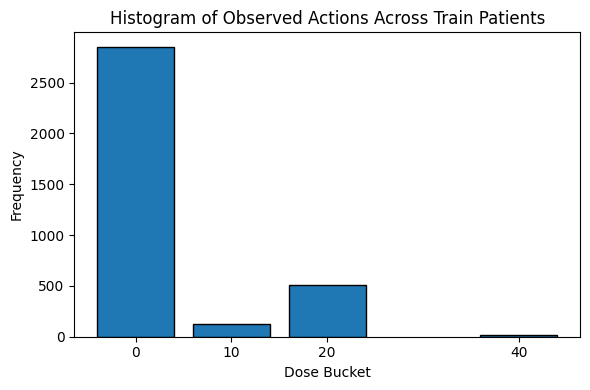

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten all actions across all patients
train_actions = np.concatenate([np.array(a, dtype=int) 
                              for a in train_expert_trajectories['actions']])

# Unique dose buckets and their counts
train_unique_buckets, counts = np.unique(train_actions, return_counts=True)

# Plot histogram
plt.figure(figsize=(6, 4))
plt.bar(train_unique_buckets, counts, width=8, edgecolor='black')
plt.xticks(train_unique_buckets)
plt.xlabel("Dose Bucket")
plt.ylabel("Frequency")
plt.title("Histogram of Observed Actions Across Train Patients")
plt.tight_layout()
plt.show()


### Fitted Q Iteration

FQI is a "batch" form of Q-learning. They have the same bellman backup, but Q-learning is online (ie samples transitions from env). FQI uses a fixed dataset and at each iteration -
- builds regression targets: y = r + max Qtarget(s',a')
- updates weights for Q and Qtar (soft update)

#### Build transitions in correct format

In [45]:
# Define consistent dose-to-index mapping for both BC and FQI
dose_to_idx = {0: 0, 10: 1, 20: 2, 40: 3}
idx_to_dose = {0: 0, 1: 10, 2: 20, 3: 40}
n_actions = 4

In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def build_transitions(expert_trajectories):
    """
    Given expert_trajectories = {'states', 'actions', 'rewards'}, this
    constructs a list `transitions` of (s, a, r, s2, a2, done) tuples exactly
    as in your original block.
    
    Returns:
        transitions: list of (s, a, r, s2, a2, done) tuples
    """
    transitions = []
    for states, actions, rewards in zip(
            expert_trajectories['states'],
            expert_trajectories['actions'],
            expert_trajectories['rewards']):
        T = len(states)
        for t in range(T):
            s  = np.array(states[t], dtype=np.float32)
            a  = np.array([actions[t]], dtype=np.float32)
            r  = np.array([rewards[t]], dtype=np.float32)
            done = 1.0 if t == T-1 else 0.0

            if t < T-1:
                s2 = np.array(states[t+1], dtype=np.float32)
                a2 = np.array([actions[t+1]], dtype=np.float32)
            else:
                # terminal next state/action dummy
                s2 = s.copy()
                a2 = np.array([0.0], dtype=np.float32)

            transitions.append((s, a, r, s2, a2, done))

    return transitions


#### Q networks

In [47]:
class FQI_QNet(nn.Module):
    """Q-network for FQI policy"""
    def __init__(self, state_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions)  # Q(s,a) for a ∈ {0,5,10,20,40}
        )
    def forward(self, s):
        return self.net(s)  # Shape: [batch_size, n_actions]


#### training loop

In [107]:
def train_fqi(transitions, num_epochs=100, lr=1e-5, batch_size=512,
              gamma=0.99, soft_tau=0.1):
    """
    Trains your FQI Q-network exactly as in the original loop, but wrapped
    so you can call it with any list of transitions.
    
    Returns:
        fqi_q_net: the trained QNet
        fqi_q_target: the final target network (after soft updates)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Infer state_dim from the first transition tuple: (s,a,r,s2,a2,done)
    state_dim = transitions[0][0].shape[0]
    
    # Initialize FQI Q-networks
    fqi_q_net = FQI_QNet(state_dim).to(device)
    fqi_q_target = FQI_QNet(state_dim).to(device)
    fqi_q_target.load_state_dict(fqi_q_net.state_dict())
    fqi_optimizer = optim.Adam(fqi_q_net.parameters(), lr=lr)
    fqi_loss_fn = nn.MSELoss(reduction='none')  # Changed to 'none' for per-sample weighting
    
    # Compute class imbalance weights
    all_a_idx = np.array([
        dose_to_idx[t[1][0] if isinstance(t[1], (list, np.ndarray)) else t[1]]
        for t in transitions
    ])
    counts = np.bincount(all_a_idx, minlength=len(dose_to_idx))
    alpha = 0.6
    inv_freq = 1.0 / (counts.astype(np.float32) ** alpha)
    inv_freq = torch.tensor(inv_freq, dtype=torch.float32, device=device)
    
    print("Training FQI Q-network...")
    for epoch in range(num_epochs):
        np.random.shuffle(transitions)
        epoch_loss = 0.0
        n_batches = 0
        for start in range(0, len(transitions), batch_size):
            batch = transitions[start:start + batch_size]
            s, a, r, s2, a2, done = zip(*batch)
            # Convert actions to indices (0-3 or 0-4, depending on buckets)
            a_idx = np.array([
                dose_to_idx[a_elem[0] if isinstance(a_elem, (list, np.ndarray)) else a_elem]
                for a_elem in a
            ])
            a2_idx = np.array([
                dose_to_idx[a2_elem[0] if isinstance(a2_elem, (list, np.ndarray)) else a2_elem]
                for a2_elem in a2
            ])
            # Convert to tensors
            s = torch.tensor(np.array(s),    device=device, dtype=torch.float32)
            a_idx = torch.tensor(a_idx,       device=device, dtype=torch.long)
            r = torch.tensor(np.array(r),     device=device, dtype=torch.float32).squeeze(-1)
            s2 = torch.tensor(np.array(s2),   device=device, dtype=torch.float32)
            a2_idx = torch.tensor(a2_idx,     device=device, dtype=torch.long)
            done = torch.tensor(np.array(done), device=device, dtype=torch.float32)
            # Compute TD‐target: r + γ (1 − done) Q_target(s2, a2)
            with torch.no_grad():
                q2_all = fqi_q_target(s2)  # [batch_size, n_actions]
                q2 = q2_all.gather(1, a2_idx.unsqueeze(-1)).squeeze(-1)
                y = r + gamma * (1 - done) * q2
            # Current Q(s,a)
            q_all = fqi_q_net(s)  # [batch_size, n_actions]
            q = q_all.gather(1, a_idx.unsqueeze(-1)).squeeze(-1)
            
            # Weighted MSE loss for class imbalance
            loss_per_sample = fqi_loss_fn(q, y)
            sample_weights = inv_freq[a_idx]
            loss = (loss_per_sample * sample_weights).mean()
            
            fqi_optimizer.zero_grad()
            loss.backward()
            fqi_optimizer.step()
            epoch_loss += loss.item()
            n_batches += 1
        # Soft update target network
        for p, pt in zip(fqi_q_net.parameters(), fqi_q_target.parameters()):
            pt.data.mul_(1 - soft_tau)
            pt.data.add_(soft_tau * p.data)
        if epoch % 10 == 0:
            avg_loss = epoch_loss / (n_batches + 1e-8)
            print(f"[FQI] Epoch {epoch:3d}  Loss: {avg_loss:.4f}")
    return fqi_q_net, fqi_q_target

In [108]:
train_transitions = build_transitions(train_expert_trajectories)
#test_transitions = build_transitions(test_expert_trajectories)

In [109]:
len(train_transitions)

3498

In [110]:
train_fqi_net, train_fqi_target = train_fqi(train_transitions)

Training FQI Q-network...
[FQI] Epoch   0  Loss: 52.9671
[FQI] Epoch  10  Loss: 52.4652
[FQI] Epoch  20  Loss: 52.2239
[FQI] Epoch  30  Loss: 52.3940
[FQI] Epoch  40  Loss: 52.7011
[FQI] Epoch  50  Loss: 52.7628
[FQI] Epoch  60  Loss: 52.8898
[FQI] Epoch  70  Loss: 53.0135
[FQI] Epoch  80  Loss: 53.2262
[FQI] Epoch  90  Loss: 53.2858


### BC policy

#### Build transitions in correct format

In [52]:
def prepare_bc_dataset(transitions, dose_to_idx):
    """
    Given `transitions = [(s,a,r,s2,a2,done), ...]`, extract:
      - bc_states: N×state_dim array of all s
      - bc_actions_idx: length‐N vector of discretized action indices
    
    Args:
        transitions: list of (s,a,r,s2,a2,done) tuples
        dose_to_idx: dict mapping raw dose → discrete index (e.g. {0:0,10:1,20:2,40:3})
    
    Returns:
        bc_states:    np.ndarray of shape [N, state_dim]
        bc_actions_idx: np.ndarray of shape [N,] with integer indices
    """
    # Stack all s_t into one (N × state_dim) array
    bc_states = np.stack([t[0] for t in transitions], axis=0)  # shape: [N, state_dim]
    
    # Extract raw action (dose) from each transition, then map to index
    raw_actions = np.stack([t[1] for t in transitions], axis=0)  # shape: [N, 1]
    bc_actions_idx = np.array([
        dose_to_idx[int(a_elem[0] if isinstance(a_elem, (list, np.ndarray)) else a_elem)]
        for a_elem in raw_actions
    ], dtype=np.int64)  # shape: [N,]
    
    return bc_states, bc_actions_idx


#### Policy network

In [53]:
class BC_Policy(nn.Module):
    """Policy network for BC - outputs action probabilities"""
    def __init__(self, state_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions)  # logits for each action
        )
    
    def forward(self, x):
        return self.net(x)  # Shape: [batch_size, n_actions]
    
    def get_action_probs(self, x):
        """Get action probabilities using softmax"""
        logits = self.forward(x)
        return torch.softmax(logits, dim=-1)
    
    def get_action(self, x, deterministic=False):
        """Sample action from policy"""
        probs = self.get_action_probs(x)
        if deterministic:
            action_idx = torch.argmax(probs, dim=-1)
        else:
            action_idx = torch.multinomial(probs, 1).squeeze(-1)
        return action_idx

#### training loop

In [54]:
def train_bc_policy(bc_states, bc_actions_idx, state_dim,
                    batch_size=512, n_epochs=100, lr=1e-3, device=None):
    """
    Train a classification BC policy to predict the discrete action index from state.
    Uses exactly the same loop as your original code, but wrapped in a function.
    
    Args:
        bc_states:       np.ndarray [N, state_dim]
        bc_actions_idx:  np.ndarray [N,]  (integer indices in [0, num_classes-1])
        state_dim:       int, dimensionality of state vector
        batch_size:      int, mini‐batch size
        n_epochs:        int, number of epochs
        lr:              float, Adam learning rate
        device:          torch.device (e.g. torch.device("cuda") or "cpu")
    
    Returns:
        bc_policy_net:   the trained BCPolicy network (nn.Module)
    """
    # Determine device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Infer number of distinct action‐indices (classes)
    num_classes = int(bc_actions_idx.max()) + 1
    
    #compute inverse-frequency weights
    counts   = np.bincount(bc_actions_idx, minlength=n_actions)   # [n0, n1, n2, n3]
    alpha = 0.8
    weights  = 1.0 / (counts**alpha)                                       # inverse freq
    weights /= weights.mean()                                     # (optional) re-scale
    class_w  = torch.tensor(weights, dtype=torch.float32, device=device)
    
    # Instantiate a BCPolicy that outputs `num_classes` logits
    bc_policy_net = BC_Policy(state_dim, num_classes).to(device)
    bc_optimizer = optim.Adam(bc_policy_net.parameters(), lr=lr)
    bc_loss_fn = nn.CrossEntropyLoss(weight=class_w)
    
    # Convert to torch tensors once
    bc_states_tensor  = torch.tensor(bc_states, dtype=torch.float32, device=device)
    bc_actions_tensor = torch.tensor(bc_actions_idx, dtype=torch.long,  device=device)
    
    print("\nTraining BC Policy...")
    for epoch in range(n_epochs):
        # Shuffle indices each epoch
        perm = torch.randperm(bc_states_tensor.size(0), device=device)
        states_shuf  = bc_states_tensor[perm]
        actions_shuf = bc_actions_tensor[perm]
        
        epoch_loss = 0.0
        n_batches = 0
        
        for start in range(0, states_shuf.size(0), batch_size):
            end = start + batch_size
            s_batch = states_shuf[start:end]
            a_batch = actions_shuf[start:end]
            
            # Forward pass: get logits over discrete classes
            action_logits = bc_policy_net(s_batch)  # shape: [batch_size, num_classes]
            
            # Compute cross‐entropy loss
            loss = bc_loss_fn(action_logits, a_batch)
            
            bc_optimizer.zero_grad()
            loss.backward()
            bc_optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        if epoch % 10 == 0:
            with torch.no_grad():
                all_logits = bc_policy_net(bc_states_tensor)
                pred_actions = torch.argmax(all_logits, dim=-1)
                accuracy = (pred_actions == bc_actions_tensor).float().mean()
                print(f"[BC] Epoch {epoch:3d}  Loss: {epoch_loss/n_batches:.4f}  "
                      f"Accuracy: {accuracy:.4f}")
    
    print("BC Training completed!\n")
    return bc_policy_net

In [55]:
# 1) Extract (states, action‐indices) for BC training

from sklearn.preprocessing import StandardScaler  # or MinMaxScaler, etc.
scaler = StandardScaler()
bc_states, bc_actions_idx = prepare_bc_dataset(train_transitions, dose_to_idx)
bc_states = scaler.fit_transform(bc_states)

state_dim = bc_states.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bc_policy_net = train_bc_policy(
    bc_states,
    bc_actions_idx,
    state_dim,
    batch_size=512,
    n_epochs=100,
    lr=1e-3,
    device=device
)


Training BC Policy...
[BC] Epoch   0  Loss: 1.4403  Accuracy: 0.2030
[BC] Epoch  10  Loss: 1.4026  Accuracy: 0.8153
[BC] Epoch  20  Loss: 1.3576  Accuracy: 0.8153
[BC] Epoch  30  Loss: 1.3085  Accuracy: 0.8153
[BC] Epoch  40  Loss: 1.2721  Accuracy: 0.8153
[BC] Epoch  50  Loss: 1.2451  Accuracy: 0.8059
[BC] Epoch  60  Loss: 1.2240  Accuracy: 0.7893
[BC] Epoch  70  Loss: 1.2053  Accuracy: 0.7716
[BC] Epoch  80  Loss: 1.1839  Accuracy: 0.7516
[BC] Epoch  90  Loss: 1.1554  Accuracy: 0.7376
BC Training completed!



### CQL

#### Build transitions in correct format

In [56]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from d3rlpy.algos import DiscreteCQLConfig
from d3rlpy.dataset import MDPDataset
from d3rlpy.metrics import TDErrorEvaluator
import tqdm

def prepare_dataset(expert_trajectories):
    # Define dose to index mapping
    dose_to_idx = {0:0, 10:1, 20:2, 40:3}
    
    all_states, all_actions, all_rewards, all_terminals = [], [], [], []
    for states, actions, rewards in zip(
        expert_trajectories['states'],
        expert_trajectories['actions'],
        expert_trajectories['rewards']
    ):
        L = min(len(states), len(actions), len(rewards))
        if L == 0:
            continue

        s = np.array(states[:L], dtype=np.float32)
        
        # Handle both [a] and a formats
        a = np.array([
            [dose_to_idx[a[0] if isinstance(a, (list, np.ndarray)) else a]] 
            for a in actions[:L]
        ], dtype=np.int32)
        
        r = np.array(rewards[:L], dtype=np.float32)
        t = np.zeros(L, dtype=bool)
        t[-1] = True  # mark end of episode

        all_states.append(s)
        all_actions.append(a)
        all_rewards.append(r)
        all_terminals.append(t)

    states = np.concatenate(all_states, axis=0)
    actions = np.concatenate(all_actions, axis=0)
    rewards = np.concatenate(all_rewards, axis=0)
    terminals = np.concatenate(all_terminals, axis=0)

    # Normalize states
    scaler = StandardScaler()
    norm_states = scaler.fit_transform(states)
    
    # Create MDPDataset
    dataset = MDPDataset(
        observations=norm_states,
        actions=actions,
        rewards=rewards,
        terminals=terminals
    )
    
    return dataset, scaler

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
import numpy as np
import torch

# since we handwrote FQI_QNet it is already a torch.nn.Module, ie. has fns like forward() and params() so OPE code can consume it directly.
# d3rlpy CQL isn’t a Module, it returns a scikit style python object
#the wrapper turns predict_value(s,a) → torch Q-matrix and fakes .parameters().

class CQLPolicyWrapper:
    def __init__(self, cql_model, scaler):          # ← accept scaler
        self.cql_model = cql_model
        self.scaler    = scaler
        cuda_ok = torch.cuda.is_available() and torch.backends.cuda.is_built()
        self.device = torch.device("cuda" if cuda_ok else "cpu")
        self.n_actions = len(dose_to_idx)

    def parameters(self):
        yield torch.tensor(0.0, device=self.device)

    def __call__(self, states_tensor: torch.Tensor) -> torch.Tensor:
        states_np  = states_tensor.detach().cpu().numpy()
        # --- NEW: match training preprocessing --------------------------
        states_np  = self.scaler.transform(states_np)
        # ----------------------------------------------------------------
        batch_size = states_np.shape[0]

        q_list = []
        for action_idx in range(self.n_actions):
            action_arr = np.full(batch_size, action_idx, dtype=np.int32)
            q_vals = self.cql_model.predict_value(states_np, action_arr)
            q_list.append(q_vals)

        q_matrix = np.stack(q_list, axis=1)
        return torch.tensor(q_matrix, device=self.device, dtype=torch.float32)


#### run cql fn

In [58]:
from d3rlpy.models.encoders import DefaultEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory

def run_discrete_cql(expert_trajectories, n_epochs=20, use_gpu=False):
    # Prepare dataset
    dataset, scaler = prepare_dataset(expert_trajectories)
    
    # Setup Discrete CQL with verified v2.x parameters
    cql = DiscreteCQLConfig(
        batch_size=512,
        learning_rate=3e-4,
        n_critics=2,                # Number of Q functions
        target_update_interval=10000,
        observation_scaler=None,     # We already scaled manually
        alpha=1.0,                  # CQL regularization weight
        q_func_factory=MeanQFunctionFactory(),  # Must be factory object
        encoder_factory=DefaultEncoderFactory() # Must be factory object, not string
    ).create(device="cuda" if use_gpu else "cpu")
    
    # Calculate total steps
    episodes = dataset.episodes
    N = sum(len(ep.observations) for ep in episodes)
    total_steps = n_epochs * N
    
    # Setup evaluator
    td_error_evaluator = TDErrorEvaluator(episodes[:10])
    
    print(f"Training Discrete CQL for ~{n_epochs} epochs ({total_steps} steps)...")
    cql.fit(
        dataset,
        n_steps=total_steps,
        evaluators={"td_error": td_error_evaluator},
        show_progress=True
    )
    
    return cql, scaler

#### evaluate 

In [59]:
cql_model, scaler = run_discrete_cql(train_expert_trajectories, n_epochs=10, use_gpu=False)

2025-06-09 14:01.08 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(10,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-06-09 14:01.08 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-06-09 14:01.08 [info     ] Action size has been automatically determined. action_size=4
Training Discrete CQL for ~10 epochs (34980 steps)...
2025-06-09 14:01.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(10,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=4)
2025-06-09 14:01.08 [debug    ] Building models...            
2025-06-09 14:01.08 [debug    ] Mode

Epoch 1/3: 100%|█| 10000/10000 [01:40<00:00, 99.60it/s, loss=49.2, td_loss=48.6,


2025-06-09 14:02.48 [info     ] DiscreteCQL_20250609140108: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.003682426357269287, 'time_algorithm_update': 0.00619704647064209, 'loss': 49.2364083694458, 'td_loss': 48.635835729599, 'conservative_loss': 0.6005726464927197, 'time_step': 0.009993711853027344, 'td_error': 3595.1241131935594} step=10000
2025-06-09 14:02.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250609140108/model_10000.d3


Epoch 2/3: 100%|█| 10000/10000 [01:47<00:00, 93.01it/s, loss=47.3, td_loss=46.5,

2025-06-09 14:04.36 [info     ] DiscreteCQL_20250609140108: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.003995100736618042, 'time_algorithm_update': 0.006583817672729492, 'loss': 47.2604648109436, 'td_loss': 46.52442810935974, 'conservative_loss': 0.7360366817861795, 'time_step': 0.010699047589302063, 'td_error': 4132.8938568165} step=20000
2025-06-09 14:04.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250609140108/model_20000.d3



Epoch 3/3: 100%|█| 10000/10000 [01:46<00:00, 93.65it/s, loss=52.3, td_loss=51.4,

2025-06-09 14:06.22 [info     ] DiscreteCQL_20250609140108: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.004004664993286133, 'time_algorithm_update': 0.006505310487747193, 'loss': 52.263910839462284, 'td_loss': 51.40658307228088, 'conservative_loss': 0.8573277711868286, 'time_step': 0.010627749729156494, 'td_error': 4853.054847467948} step=30000
2025-06-09 14:06.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250609140108/model_30000.d3


In [60]:
#Create wrapper for OPE compatibility
cql_wrapper = CQLPolicyWrapper(cql_model, scaler)

In [61]:
# After running, check action space size is correct (should be 4)
print("Action space size:", cql_model.impl.action_size) 

Action space size: 4


### Plot action dist

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch


def plot_action_distributions(expert_trajectories,
                              fqi_model,
                              bc_model,
                              cql_wrapper,
                              scaler):
    """
    Draw 4 side-by-side histograms (2×2 grid) of dose selection:
        ▸ Clinician  ▸ BC  ▸ FQI  ▸ CQL
    Uses a common random subset of states so the distributions are
    directly comparable.  Colour scheme:
        blue = clinician, orange = BC, green = FQI, red = CQL
    """
    dose_buckets = [0, 10, 20, 40]
    bins = [-5, 5, 15, 30, 50]

    # ── sample identical state set ──────────────────────────────────────
    raw_states = np.concatenate(expert_trajectories["states"])
    raw_actions = np.concatenate(expert_trajectories["actions"]).flatten()

    perm = np.random.permutation(len(raw_states))
    raw_states = raw_states[perm]
    raw_actions = raw_actions[perm]

    scaled_states = scaler.transform(raw_states)

    # ── clinician actions ───────────────────────────────────────────────
    clinician_doses = raw_actions

    # BC predictions  ► use argmax over logits
    with torch.no_grad():
        logits = bc_model(torch.tensor(scaled_states, dtype=torch.float32)).cpu().numpy()
    bc_doses = np.array([dose_buckets[idx] for idx in np.argmax(logits, axis=1)])


    # ── FQI predictions (arg-max Q) ─────────────────────────────────────
    with torch.no_grad():
        q_vals = fqi_model(torch.tensor(raw_states,
                                        dtype=torch.float32)).cpu().numpy()
    fqi_doses = np.array([dose_buckets[np.argmax(q)] for q in q_vals])

    # ── CQL predictions (wrapper Q-matrix) ──────────────────────────────
    with torch.no_grad():
        q_cql = cql_wrapper(torch.tensor(raw_states,
                                         dtype=torch.float32)).cpu().numpy()
    cql_doses = np.array([dose_buckets[i] for i in np.argmax(q_cql, axis=1)])

    # ── plotting (4 quadrants) ──────────────────────────────────────────
    fig, axes = plt.subplots(2, 2, figsize=(10, 7))
    plots = [
        (axes[0, 0], clinician_doses, "Clinician", "tab:blue"),
        (axes[0, 1], bc_doses,        "BC",        "tab:orange"),
        (axes[1, 0], fqi_doses,       "FQI",       "tab:green"),
        (axes[1, 1], cql_doses,       "CQL",       "tab:red"),
    ]

    for ax, doses, label, color in plots:
        sns.histplot(
            doses,
            bins=bins,
            stat="probability",
            discrete=True,
            shrink=0.8,
            edgecolor="k",
            color=color,
            alpha=0.5,
            ax=ax
        )
        ax.set_title(f"{label} (n={len(doses)})")
        ax.set_xticks(dose_buckets)
        ax.set_xlim(-5, 45)
        ax.set_xlabel("Dose (mEq)")
        ax.set_ylabel("Proportion")

        # mark mean
        mean_dose = np.mean(doses)
        ax.axvline(mean_dose, color=color, linestyle="--", alpha=0.7)
        ax.text(mean_dose + 1.5,
                ax.get_ylim()[1] * 0.9,
                f"{mean_dose:.1f}",
                color=color,
                fontsize=8)

    plt.tight_layout()
    plt.show()


In [112]:
test_logits = bc_policy_net(torch.tensor(bc_states[:30]).float())
print("Predicted buckets:", np.argmax(test_logits.detach().numpy(), axis=1)[:30])

Predicted buckets: [2 0 0 0 0 0 2 3 0 0 0 0 0 2 2 2 0 0 2 0 1 2 2 0 0 2 0 0 0 0]


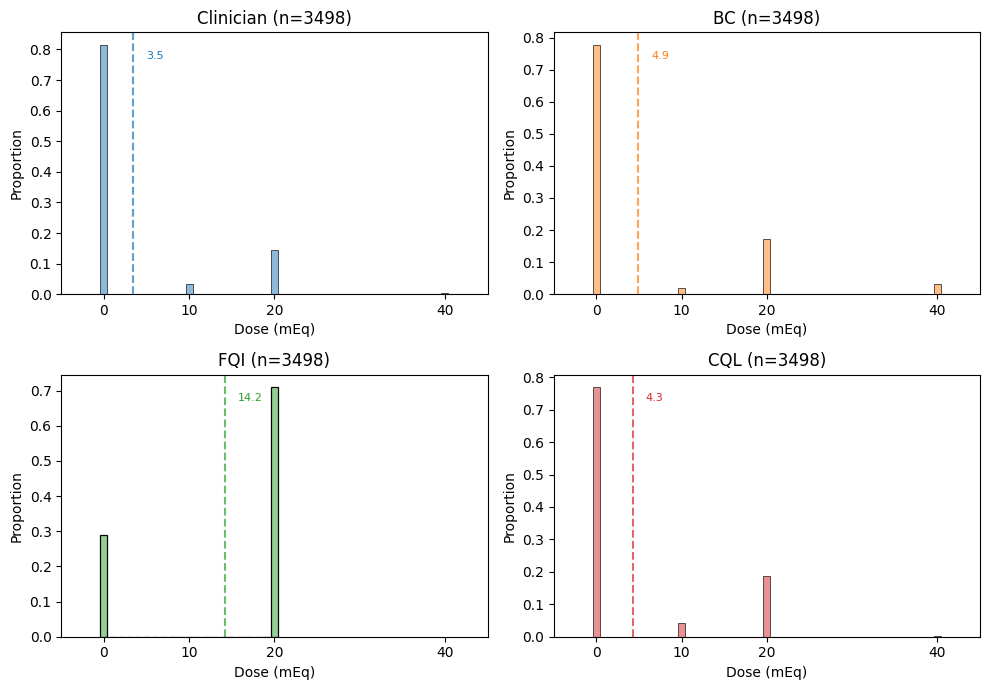

In [113]:
# ------------------------------------------------------------
# Assume these objects already exist in your notebook session:
#   • train_expert_trajectories   (dict with 'states' 'actions' 'rewards')
#   • train_fqi_net               (torch nn.Module, discrete Q-network)
#   • bc_model                    (torch nn.Module, behaviour-cloning net)
#   • cql_model                   (d3rlpy DiscreteCQL model, already fitted)
#   • scaler                      (sklearn StandardScaler fitted on states)
#   • device                     = "cuda" or "cpu" — whichever you used
# ------------------------------------------------------------

plot_action_distributions(
    expert_trajectories=train_expert_trajectories,
    fqi_model=train_fqi_net,
    bc_model=bc_policy_net,
    cql_wrapper=cql_wrapper,
    scaler=scaler,
)


## Weighted Importance Sampling: OPE

In [114]:
import numpy as np
import torch
import torch.nn.functional as F

def compute_policy_probabilities(policy_net, states, actions, policy_type='bc'):
    """
    Compute π(a|s) for given states and actions
    
    Args:
        policy_net: trained policy network (BC, FQI or CQL)
        states: numpy array of states [N, state_dim]
        actions: numpy array of actions [N, 1] 
        policy_type: 'bc', 'fqi' or 'cql'
    
    Returns:
        probabilities: numpy array of π(a|s) values [N,]
    """
    device = next(policy_net.parameters()).device
    states_tensor = torch.tensor(states, dtype=torch.float32, device=device)
    
    with torch.no_grad():            
        if policy_type == 'bc':
            logits = policy_net(states_tensor)                 # [N, 4]
            probs  = F.softmax(logits, dim=1)                  # [N, 4]
            #print(probs.shape)
            # map raw dose to its discrete index once
            action_indices = torch.tensor(
                [dose_to_idx[int(a[0])] for a in actions],
                dtype=torch.long, device=device
            )                                                  # [N,]
            # probability assigned to the taken action
            action_probs = probs.gather(1, action_indices.unsqueeze(1)).squeeze(1)
            
        elif policy_type == 'fqi':
            # For FQI: use epsilon-greedy or softmax policy based on Q-values
            q_values = policy_net(states_tensor)  # [N, 4]
            #print(q_values.shape)
            
            # Softmax policy (more common for continuous evaluation)
            temperature = 1.0  # adjust as needed
            probs = F.softmax(q_values / temperature, dim=1)  # [N, 4]
            
            # Get probability for actual action taken
            action_indices = torch.tensor([dose_to_idx[int(a[0])] for a in actions], 
                                        dtype=torch.long, device=device)
            action_probs = probs.gather(1, action_indices.unsqueeze(1)).squeeze(1)
        
        elif policy_type == 'cql':
            # Same logic as FQI – convert CQL Q-values to a softmax policy
            q_values = policy_net(states_tensor)               # [N, 4]
            temperature = 100.0
            probs = F.softmax(q_values / temperature, dim=1)   # [N, 4]

            action_indices = torch.tensor(
                [dose_to_idx[int(a[0])] for a in actions],
                dtype=torch.long, device=device
            )
            action_probs = probs.gather(1, action_indices.unsqueeze(1)).squeeze(1)
    
    return action_probs.cpu().numpy()

def compute_importance_weights(bc_policy_net,
                               target_q_net,                # was fqi_q_net
                               expert_trajectories,
                               target_type='fqi'):          # allows 'fqi' or 'cql'
    """
    Importance-sampling weights for each trajectory.

    Args
    ----
    bc_policy_net   : trained BC network (behaviour policy)
    target_q_net    : trained Q-value network from FQI, CQL, etc. (target policy)
    expert_trajectories : dict with keys 'states', 'actions', 'rewards'
    target_type     : string passed to `compute_policy_probabilities`
                      ('fqi' by default, set to 'cql' when evaluating CQL)

    Returns
    -------
    weights          : list of raw importance weights  (one per trajectory)
    clipped_weights  : same list after clipping
    """
    trajectory_weights          = []
    trajectory_weights_clipped  = []

    for states, actions, rewards in zip(expert_trajectories['states'],
                                        expert_trajectories['actions'],
                                        expert_trajectories['rewards']):

        if len(states) == 0:        # skip empty trajectories
            continue

        #convert to numpy arrays
        states_np  = np.asarray(states,  dtype=np.float32)
        actions_np = np.asarray([[a] for a in actions], dtype=np.float32)

        # Compute policy probabilities
        pi_b      = compute_policy_probabilities(bc_policy_net, states_np, actions_np, 'bc') #pi_b = behavior policy/ expert policy
        pi_e  = compute_policy_probabilities(target_q_net, states_np, actions_np, target_type) #pi_e = evaluation policy/ target policy

        # Avoid division by zero
        pi_b     = np.maximum(pi_b, 1e-8)
        pi_e = np.maximum(pi_e, 1e-8)

        # Per-trajectory weight  ∏_t  π_t / π_b
        weight            = np.prod(pi_e / pi_b)
        weight_clipped    = np.clip(weight, 0.1, 10.0) # Clip weights to prevent extreme values (common in practice)

        trajectory_weights.append(weight)
        trajectory_weights_clipped.append(weight_clipped)

    return trajectory_weights, trajectory_weights_clipped


def importance_sampling_estimator(expert_trajectories, weights, use_clipped=True):
    """
    Compute IS and WIS estimators of policy value
    
    Args:
        expert_trajectories: dict with 'states', 'actions', 'rewards'
        weights: list of importance weights for each trajectory
        use_clipped: whether to use clipped weights
    
    Returns:
        is_estimate: basic importance sampling estimate
        wis_estimate: weighted importance sampling estimate
    """
    trajectory_returns = []
    valid_weights = []
    
    # Compute returns for each trajectory
    for traj_idx, (states, actions, rewards) in enumerate(zip(
        expert_trajectories['states'],
        expert_trajectories['actions'],
        expert_trajectories['rewards']
    )):
        if len(rewards) == 0:
            continue
            
        # Compute discounted return
        gamma = 0.99
        discounted_return = 0.0
        for t, reward in enumerate(rewards):
            discounted_return += (gamma ** t) * reward
        
        trajectory_returns.append(discounted_return)
        valid_weights.append(weights[traj_idx])
    
    trajectory_returns = np.array(trajectory_returns)
    valid_weights = np.array(valid_weights)
    
    # Basic IS estimator: (1/N) * Σ(w_i * R_i)
    is_estimate = np.mean(valid_weights * trajectory_returns)
    
    # Weighted IS estimator: Σ(w_i * R_i) / Σ(w_i)
    wis_estimate = np.sum(valid_weights * trajectory_returns) / np.sum(valid_weights)
    
    return is_estimate, wis_estimate

    
def evaluate_policies_with_ope(bc_policy_net, target_q_net, expert_trajectories, target_type):
    """
    Complete OPE evaluation pipeline
    """
    print("Computing importance sampling weights...")
    weights, weights_clipped = compute_importance_weights(bc_policy_net, target_q_net, expert_trajectories, target_type)
    
    print(f"Weight statistics:")
    print(f"  Unclipped: mean={np.mean(weights):.4f}, std={np.std(weights):.4f}")
    print(f"  Clipped:   mean={np.mean(weights_clipped):.4f}, std={np.std(weights_clipped):.4f}")
    
    # Evaluate with unclipped weights
    is_est, wis_est = importance_sampling_estimator(expert_trajectories, weights, use_clipped=False)
    print(f"\nUnclipped weights:")
    print(f"  IS estimate:  {is_est:.4f}")
    print(f"  WIS estimate: {wis_est:.4f}")
    
    # Evaluate with clipped weights  
    is_est_clip, wis_est_clip = importance_sampling_estimator(expert_trajectories, weights_clipped, use_clipped=True)
    print(f"\nClipped weights:")
    print(f"  IS estimate:  {is_est_clip:.4f}")
    print(f"  WIS estimate: {wis_est_clip:.4f}")
    
    return {
        'weights': weights,
        'weights_clipped': weights_clipped,
        'is_unclipped': is_est,
        'wis_unclipped': wis_est,
        'is_clipped': is_est_clip,
        'wis_clipped': wis_est_clip
    }


In [115]:
results = evaluate_policies_with_ope(bc_policy_net, train_fqi_net, train_expert_trajectories, 'fqi')

Computing importance sampling weights...
Weight statistics:
  Unclipped: mean=inf, std=nan
  Clipped:   mean=5.8902, std=4.7973

Unclipped weights:
  IS estimate:  inf
  WIS estimate: nan

Clipped weights:
  IS estimate:  8333.0010
  WIS estimate: 1414.7344


/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/var/folders/67/rsds3lxj78x4092pycb6cnkh0000gn/T/ipykernel_89806/2124561527.py:155: RuntimeWarning: invalid value encountered in scalar divide
  wis_estimate = np.sum(valid_weights * trajectory_returns) / np.sum(valid_weights)


In [116]:
results = evaluate_policies_with_ope(bc_policy_net, cql_wrapper, train_expert_trajectories, 'cql')

Computing importance sampling weights...
Weight statistics:
  Unclipped: mean=inf, std=nan
  Clipped:   mean=10.0000, std=0.0000

Unclipped weights:
  IS estimate:  inf
  WIS estimate: nan

Clipped weights:
  IS estimate:  13191.7549
  WIS estimate: 1319.1755


/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning

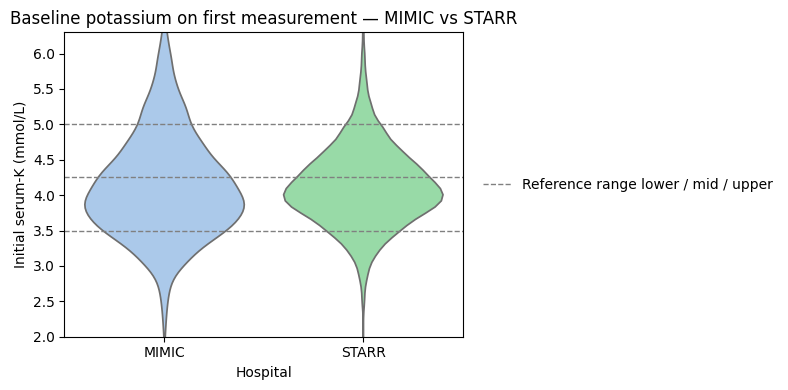

In [133]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# ---------------------------------------------------------------
# 0.  Combine cohorts
# ---------------------------------------------------------------
potassium_long = pd.concat(
    [first_k_mimic[['Hospital', 'K_initial']],
     first_k_starr[['Hospital', 'K_initial']]],
    ignore_index=True
)

# ---------------------------------------------------------------
# 1.  Pastel violin colours
# ---------------------------------------------------------------
palette = {'MIMIC': sns.color_palette("pastel")[0],   # light blue
           'STARR': sns.color_palette("pastel")[2]}   # light green

fig, ax = plt.subplots(figsize=(8, 4))

sns.violinplot(
    data=potassium_long,
    x='Hospital', y='K_initial',
    hue='Hospital',
    palette=palette,
    inner=None,          # violins only
    legend=False,
    cut=0,
    ax=ax
)

# ---------------------------------------------------------------
# 2.  Grey clinical reference lines
# ---------------------------------------------------------------
for y in [3.5, 4.25, 5.0]:          # lower, mid, upper
    ax.axhline(y, ls='--', lw=1.0, color='grey')

# ---------------------------------------------------------------
# 3.  Legend outside plot (only clinical lines)
# ---------------------------------------------------------------
ax.legend([plt.Line2D([], [], color='grey', ls='--', lw=1)],
          ["Reference range lower / mid / upper"],
          loc='center left',
          bbox_to_anchor=(1.02, 0.5),
          frameon=False)

# ---------------------------------------------------------------
# 4.  Final cosmetics
# ---------------------------------------------------------------
ax.set_ylim(2, 6.3)
ax.set_ylabel('Initial serum-K (mmol/L)')
ax.set_title('Baseline potassium on first measurement — MIMIC vs STARR')
plt.tight_layout()
plt.show()


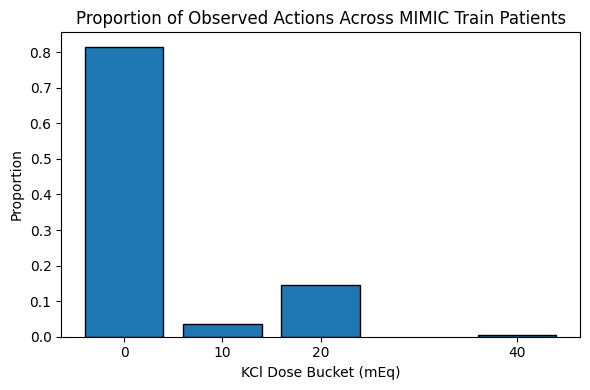

In [118]:
import numpy as np
import matplotlib.pyplot as plt

def flatten_actions(expert_traj):
    """Return 1-D numpy array of all clinician doses."""
    return np.concatenate([np.array(a, dtype=int) for a in expert_traj['actions']])

# — MIMIC cohort —
mimic_actions = flatten_actions(train_expert_trajectories)
all_buckets = np.array([0, 10, 20, 40])

# compute proportions
total_mimic = len(mimic_actions)
mimic_props = [np.sum(mimic_actions == b) / total_mimic for b in all_buckets]

# plot
plt.figure(figsize=(6, 4))
plt.bar(all_buckets, mimic_props, width=8, edgecolor='black')
plt.xticks(all_buckets)
plt.xlabel("KCl Dose Bucket (mEq)")
plt.ylabel("Proportion")
plt.title("Proportion of Observed Actions Across MIMIC Train Patients")
plt.tight_layout()
plt.show()
